# Importing Packages & Set Up Data Layout

## Preprocessing Information for the Given Data.

A high-pass filter with a 30 Hz cut-off frequency and a power line notch filter (50 Hz) were used. All recordings are artifact-free EEG segments of 60 seconds duration. At the stage of data preprocessing, the Independent Component Analysis (ICA) was used to eliminate the artifacts (eyes, muscle, and cardiac overlapping of the cardiac pulsation). The arithmetic task was the serial subtraction of two numbers. Each trial started with the communication orally 4-digit (minuend) and 2-digit (subtrahend) numbers (e.g. 3141 and 42).

In [4]:
# Let's load some packages we need (pip install mne)
import mne
import mne.viz
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# ! pip install mne

# Read raw data files where each file contains a run
files = ['../../datasets/HW2Datasets/Subject06_1.edf', '../../datasets/HW2Datasets/Subject06_2.edf', '../../datasets/HW2Datasets/Subject07_1.edf', '../../datasets/HW2Datasets/Subject07_2.edf']

# Read the raw EDF files into an array
raws = [read_raw_edf(f, preload=True) for f in files]

# Loop through the array and make the following changes to the raw files
for raw in raws:

    # Rename the raw channels
    raw.rename_channels({'EEG F3':'F3', 'EEG F4':'F4',
                            'EEG Fp1':'Fp1', 'EEG Fp2':'Fp2', 'EEG F7':'F7', 'EEG F8':'F8',
                            'EEG T3':'T3', 'EEG T4':'T4', 'EEG C3':'C3', 'EEG C4':'C4',
                            'EEG T5':'T5', 'EEG T6':'T6', 'EEG P3':'P3', 'EEG P4':'P4',
                            'EEG O1':'O1', 'EEG O2':'O2', 'EEG Fz':'Fz', 'EEG Cz':'Cz',
                            'EEG Pz':'Pz', 'EEG A2-A1':'A2', 'ECG ECG':'ECG'})


    # Set channel types
    raw.set_channel_types({'ECG':'ecg'})

    # Define the channel locations
    raw.set_montage(mne.channels.make_standard_montage('standard_1020'))

    # Print Raw Channel Names for double checking
    print(raw.ch_names)

# Rename the raws with more insightfull names
subject6_background = raws[0] # Subject 6 background raw
subject6_task = raws[1] # Subject 6 task raw
subject7_background = raws[2] # Subject 7 background raw
subject7_task = raws[3] # Subject 7 task raw

# Function to segment data into non-overlapping windows of length 300 samples
def segment_data(raw, window_size=300):
    data = raw.get_data()  # Get the raw data
    n_channels, n_samples = data.shape # get dimensions
    print("Data Shape Before:", n_channels, n_samples) # display dimensions for understanding
    n_windows = n_samples // window_size  # Number of windows

    # Reshape data into (n_channels, n_windows, window_size)
    segmented_data = data[:, :n_windows * window_size].reshape(n_channels, n_windows, window_size)
    print("Data Shape After:", n_channels, n_windows, window_size) # display shape after reshaping

    return segmented_data # return the segmented data


# Segment each raw file into windows
subject6_background_segments = segment_data(subject6_background)
subject6_task_segments = segment_data(subject6_task)
subject7_background_segments = segment_data(subject7_background)
subject7_task_segments = segment_data(subject7_task)

# Create labels: 0 for background, 1 for task
subject6_background_labels = np.zeros(subject6_background_segments.shape[1])
subject6_task_labels = np.ones(subject6_task_segments.shape[1])
subject7_background_labels = np.zeros(subject7_background_segments.shape[1])
subject7_task_labels = np.ones(subject7_task_segments.shape[1])

# Concatenate data for both subjects
X = np.concatenate([subject6_background_segments, subject6_task_segments, 
                    subject7_background_segments, subject7_task_segments], axis=1)

# Concatenate labels for both subjects
y = np.concatenate([subject6_background_labels, subject6_task_labels,
                    subject7_background_labels, subject7_task_labels])

# X shape will be (n_channels, total_windows * window_size), and y will be the labels for each window
print("Shape of segmented data:", X.shape) # See the dimensions of X
print("Shape of labels:", y.shape) # See the dimensions of y

Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject07_2.edf...
EDF file de

# Q3) 
## Apply three different feature engineering methods of your choice (feature extraction, transformation, or selection), and repeat the analysis in (Q2). Discuss how your results differ and how you could improve your results.

The 3 feature engineering methods I have choosen for Q3 are SMOTE, stardard normalization, and FFT. The reason why i choose FFT is because you can gather more clearly defined features through FFT than raw data, this could improve all metrics further. In SMOTE it distributes the samples in an evenly distributed way where the ML model finds more complicated relationships that gives something better than a y=0 model (clear improvement in balanced accuracy and f1 score). Lastly, standard normalization should help all datapoints be located within the sigmoid function to allow for clear classification (improve all metrics).

In [5]:
# Import ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# Import library for k-folds
from sklearn.model_selection import StratifiedKFold

# Import library for fast fourier transform
from scipy.fft import fft

# Import library for equal data distribution
from imblearn.over_sampling import SMOTE

# Import library for normalization
from sklearn.preprocessing import StandardScaler

# Make FFT function
def apply_fft(X, n_fft=300):
    # X is of shape (n_samples, n_channels, n_points_per_window)
    X_fft = np.abs(fft(X, n=n_fft, axis=2))  # FFT along the last axis (window axis)
    return X_fft[:, :, :n_fft//2]  # Take only the positive frequencies (half of the spectrum)

# Apply FFT to the data (shape will still be (n_samples, n_channels, n_features_per_channel))
X_fft = apply_fft(X)

# Reshape the data for model training (n_samples, n_features)
X_reshaped = X_fft.reshape(X_fft.shape[1], -1)  # (n_windows, n_channels * window_size)

# Apply SMOTE after transformation
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Create k-folds where k=5
skf = StratifiedKFold(n_splits=5)
folds = skf.split(X_resampled, y_resampled) # make different folds for X and y

train_idxs=[] # store training indexes
test_idxs=[] # store test indexes
total_y_test = [] # store all y test values
total_y_pred = [] # store all y pred values

# Loop through all folds
for i, fold in enumerate(folds):
    train_idx, test_idx = fold # Grab indexes from fold
    train_idxs.append(train_idx) # append training indexes to the training list
    test_idxs.append(test_idx) # append testing indexes to the testing list

accuracy_arr = []
balanced_accuracy_arr = []
f1_score_arr = []

# Loop through the 5 folds made previously
for i in range(5):
    X_train = X_resampled[train_idxs[i][:]] # Load in the training X values from index i
    y_train = y_resampled[train_idxs[i][:]] # Load in the training y values from index i
    X_test = X_resampled[test_idxs[i][:]] # Load in the testing X values from index i
    y_test = y_resampled[test_idxs[i][:]] # Load in the testing y values from index i

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Extend total y test array
    total_y_test.extend(y_test)

    # Extend total y pred array
    total_y_pred.extend(y_pred)

    # Print out the current fold we are itterating over
    print("Examining fold %i" % (i + 1))

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_arr.append(accuracy) # Append accuracy to array

    # Evaluate the model using balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    balanced_accuracy_arr.append(balanced_accuracy) # Append balanced accuracy to array

    # Evaluate the model using f1 score
    f1 = f1_score(y_test, y_pred)
    f1_score_arr.append(f1) # Append f1 score to array

    # Print accuracy
    print(f"Accuracy: {accuracy*100:.2f}%")

    # Print balanced accuracy
    print(f"Balanced Accuracy: {balanced_accuracy*100:.2f}%")

    # Print f1 score
    print(f"F1 Score: {f1*100:.2f}%\n")

print(f"Average Accuracy Score: {np.sum(accuracy_arr)*100/5:.2f}%")
print(f"Average Balanced Accuracy Score: {np.sum(balanced_accuracy_arr)*100/5:.2f}%")
print(f"Average F1 Score: {np.sum(f1_score_arr)*100/5:.2f}%")

Examining fold 1
Accuracy: 70.37%
Balanced Accuracy: 70.40%
F1 Score: 72.31%

Examining fold 2
Accuracy: 76.95%
Balanced Accuracy: 77.00%
F1 Score: 74.07%

Examining fold 3
Accuracy: 86.78%
Balanced Accuracy: 86.78%
F1 Score: 87.69%

Examining fold 4
Accuracy: 85.54%
Balanced Accuracy: 85.54%
F1 Score: 86.59%

Examining fold 5
Accuracy: 79.75%
Balanced Accuracy: 79.75%
F1 Score: 80.63%

Average Accuracy Score: 79.88%
Average Balanced Accuracy Score: 79.89%
Average F1 Score: 80.26%


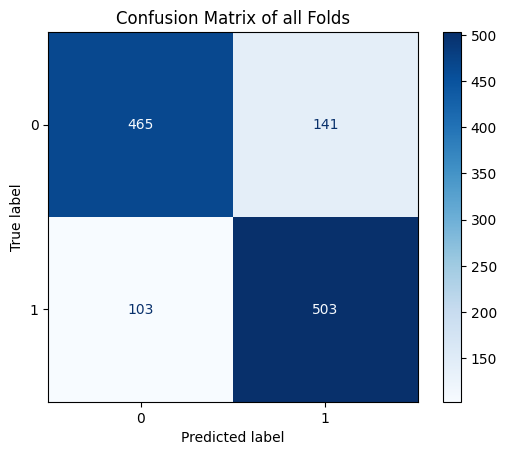

True Negatives (TN): 465
False Positives (FP): 141
False Negatives (FN): 103
True Positives (TP): 503


In [6]:
# Import library for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(total_y_test, total_y_pred)

# Construct the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)  # plot the matrix
plt.title("Confusion Matrix of all Folds") # title matrix
plt.show() # show matrix

# Get the confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}") # Show the Number of True Negatives
print(f"False Positives (FP): {fp}") # Show the Number of False Positives
print(f"False Negatives (FN): {fn}") # Show the Number of False Negatives
print(f"True Positives (TP): {tp}") # Show the Number of True Positives 

Unlike Q2, our Q3 results are **Drastically** better than both Q1 and Q2. Main reason is due to the feature engineering techniques added above being super beneficial to the data. I will not re-explain what they do here (as I have done that in a previous section), but I will talk about the changes of the results. The model this time around actually tries to make y=1 predictions sometimes, which is straight up better than what we had before (you can see this b/c the number of TP and FP are not 0). 

When it comes to the metrics, the F1 score is on average 80.6% which is *way better* than the 0% we had before. This tells us the model is making correct decisions for both y=0 and y=1 cases. Our balanced accuray is 79.89% which is 29.89 percentage points higher than what we had before (for the same reason as the F1 score increase basically). Surprisingly the Accuracy also increased to 79.88% which is higher than the before metric which was around 74% and this is because the model was predicting y=1 cases for the most part correctly, however it would still miss more y=0 cases than before which would decrease this metric to not reward the change made as much as the F1 score did for example. 

I could potentially improve results by testing and added more feature engineering methods, like adding powerbands, or removing higher frequencies from FFT, PCA, and many many more. However Another clear way I can think of is now changing the model itself, that being either the hyperparameters of the model or the model class (logistic regression vs random forest for example). However change in model and getting the best out of that model could involve different feature engineering methods.